Aspect to investigate on this data science project:    
The imagined task from AirBnB team was to investigate whether host's communicational behaviour
reflects superhostness.  
AirBnB has been struggling how to redefine superhost status, problem has arisen from the increasing number of superhosts, inflating the very meaning of it. 

In [378]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix

### Bring data to Pandas dataframe  
Inspect the first rows

In [379]:
path_to_file = 'data/listings.csv'
df = pd.read_csv(path_to_file)
df2 = df.copy()                     # Will be used later..
df.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20250306035151,2025-03-13,city scrape,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.82,4.73,4.79,NaN,f,1,1,0,0,3.60
1,5769,https://www.airbnb.com/rooms/5769,20250306035151,2025-03-11,previous scrape,NW Austin Room,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.94,4.77,4.92,NaN,f,1,0,1,0,1.65
2,6413,https://www.airbnb.com/rooms/6413,20250306035151,2025-03-13,city scrape,Gem of a Studio near Downtown,"Great studio apartment, perfect a single perso...",Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/hosting/Hosti...,13879,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.66


- Selecting columns to be used in this work  


In [380]:
cols = ['host_response_time', 'host_response_rate', 'review_scores_communication', 'host_is_superhost']
df = df[cols]
df.head()

,host_response_time,host_response_rate,review_scores_communication,host_is_superhost
0,within a few hours,100%,4.82,t
1,NaN,NaN,4.94,f
2,within a day,100%,4.98,t
3,within an hour,100%,4.98,t
4,within a day,90%,4.88,f


Clean data


In [381]:
df['host_response_rate'] = df['host_response_rate'].str[:-1]
df['host_is_superhost'] = df['host_is_superhost'].replace({'t': 'true', 'f': 'false'})

df.head()

,host_response_time,host_response_rate,review_scores_communication,host_is_superhost
0,within a few hours,100,4.82,true
1,NaN,NaN,4.94,false
2,within a day,100,4.98,true
3,within an hour,100,4.98,true
4,within a day,90,4.88,false


- NaN values  
We see that ~4600 rows are lost when dropping rows with missing values.  
Remaining (10816 entries) is still a good size dataset.   
Another option would be to fill the missing values by calculating e.g. a mean from entries with values.  
Because the number of rows with missing values is third of the dataset I opt for dropping rows with missing values to avoid skewing.  

In [382]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(15431, 4)
(9143, 4)


### Inspecting data
#### Visualizing features  
- Response time

<AxesSubplot:xlabel='host_response_time', ylabel='count'>

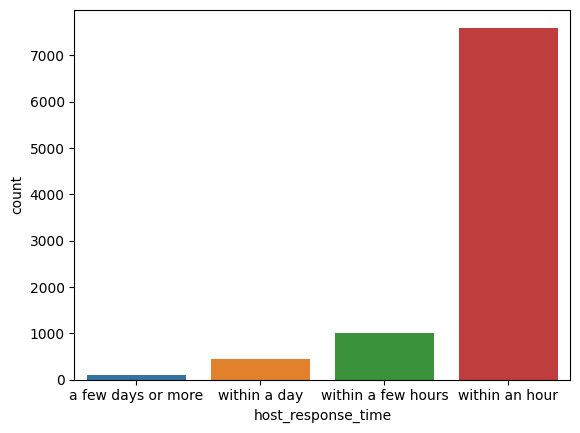

In [383]:
sns.countplot(data=df.sort_values('host_response_time'), x='host_response_time', )

- Response rate  
Changing datatype to int  
Temporarily sort by ascending values for visualization

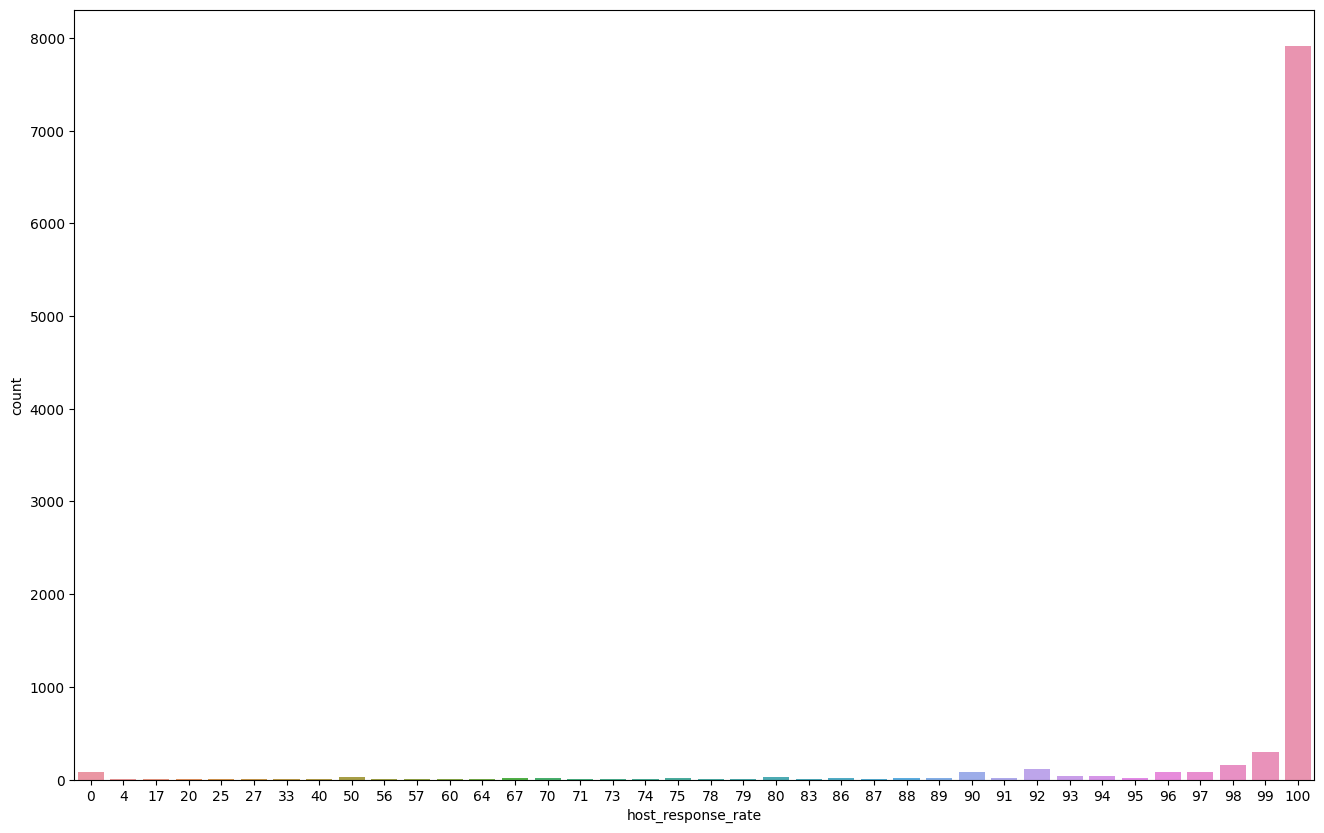

In [384]:
df['host_response_rate'] = df['host_response_rate'].astype(int)
graph = sns.countplot(data=df.sort_values('host_response_rate'), x= 'host_response_rate', )
graph.figure.set_size_inches(16, 10)


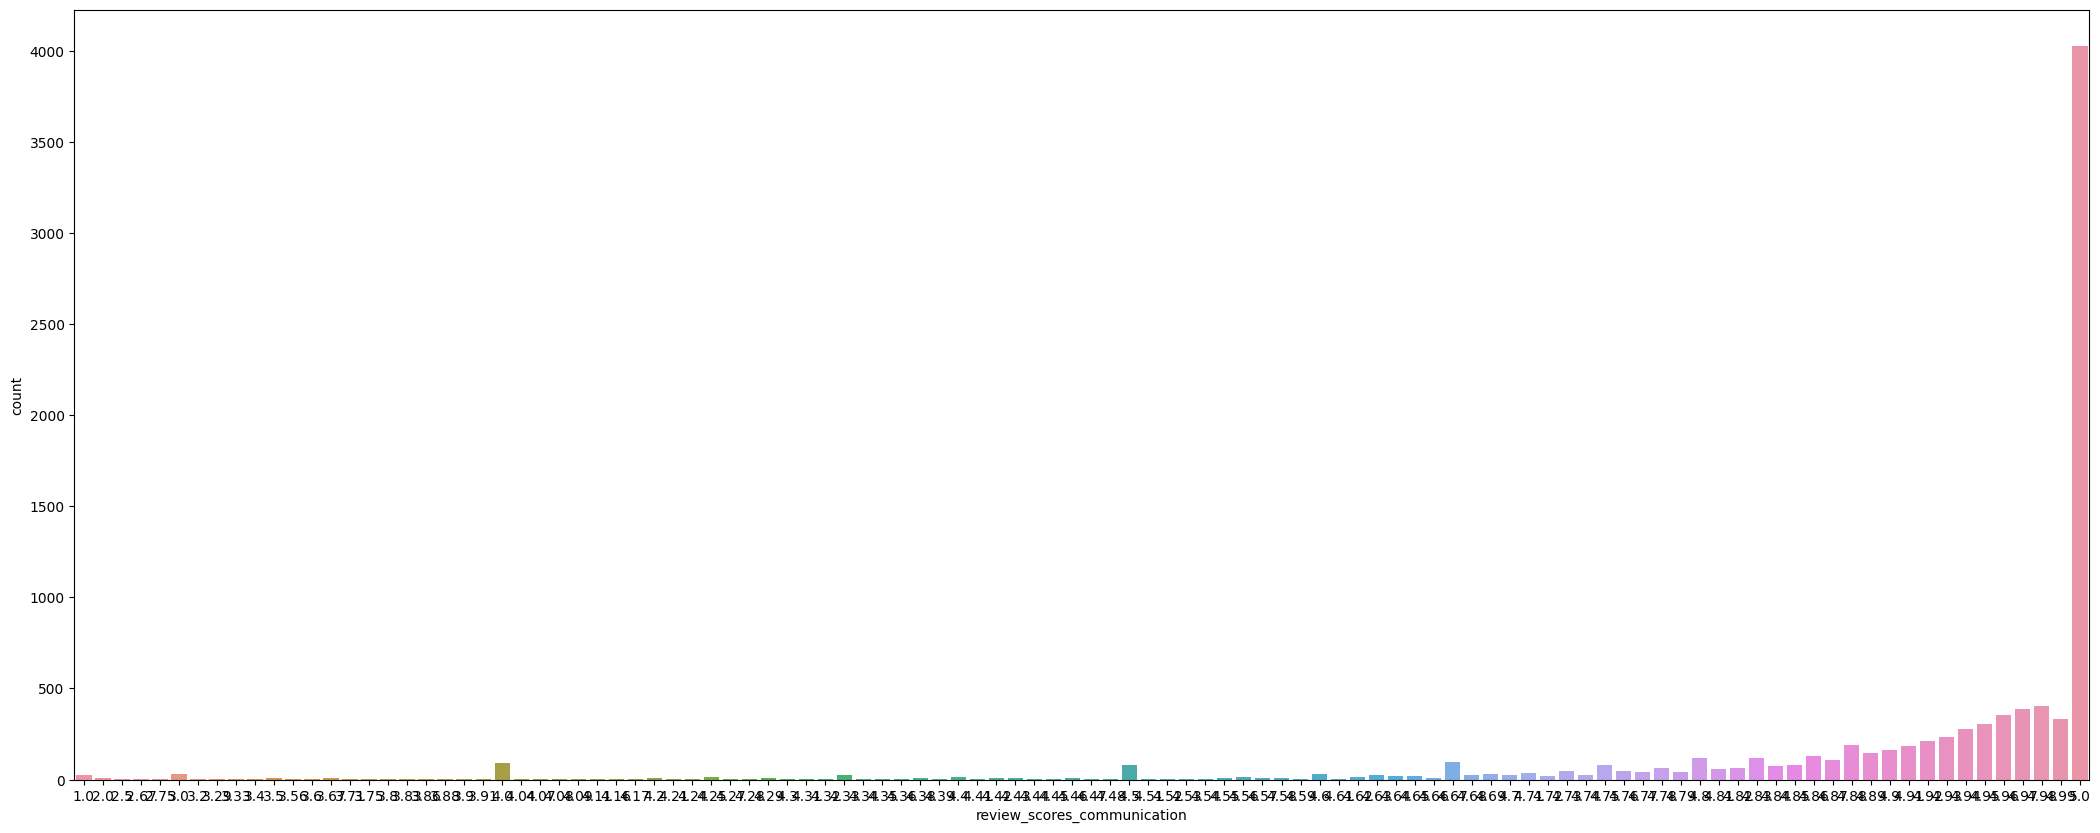

In [385]:
graph = sns.countplot(data=df, x='review_scores_communication')
graph.figure.set_size_inches(26, 10)


- Superhostness  

<AxesSubplot:xlabel='host_is_superhost', ylabel='count'>

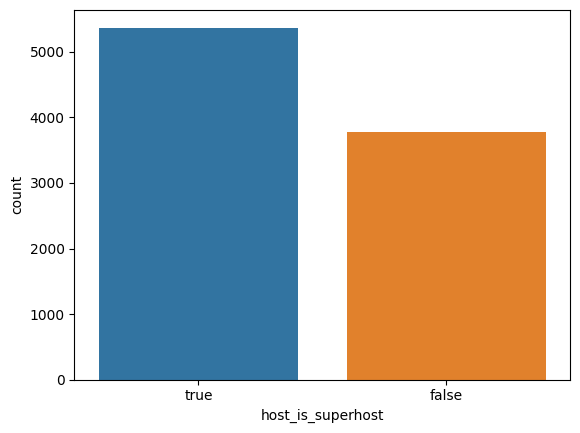

In [386]:
sns.countplot(data=df, x ='host_is_superhost',  )

##### Conclusions from visualizations  
We can see that the vast majority of hosts:
- responses within an hour.  
- responses to all all messages.    
**but** being superhost is somewhat equally distributed.  

Distribution in numbers:

In [387]:
bold = "\033[1m"
reset = "\033[0m"
print(f"{bold}Response time:{reset} \n{df['host_response_time'].value_counts()}\n")
print(f"{bold}Response rate:{reset} \n{df['host_response_rate'].value_counts()}\n")
print(f"{bold}Response rate:{reset} \n{df['review_scores_communication'].value_counts()}\n")
print(f"{bold}Superhostness: {reset}\n{df['host_is_superhost'].value_counts()}")

Response time: 
within an hour        7603
within a few hours    1000
within a day           441
a few days or more      99
Name: host_response_time, dtype: int64

Response rate: 
100    7910
99      299
98      159
92      112
90       87
97       86
0        85
96       77
93       40
94       38
80       32
50       27
75       20
95       20
89       19
67       18
86       13
88       13
70       13
91       12
83        9
60        8
87        7
57        7
79        5
78        5
33        4
56        3
71        2
17        2
25        2
40        2
27        2
74        1
64        1
20        1
4         1
73        1
Name: host_response_rate, dtype: int64

Response rate: 
5.00    4025
4.98     402
4.97     386
4.96     354
4.99     332
        ... 
4.27       1
3.29       1
3.88       1
4.34       1
3.91       1
Name: review_scores_communication, Length: 106, dtype: int64

Superhostness: 
true     5371
false    3772
Name: host_is_superhost, dtype: int64


Convert response_times to numbers.  

In [388]:
df.replace({'within an hour':4, 'within a few hours': 3, 'within a day': 2, 'a few days or more': 1}, inplace=True)
df.head()

,host_response_time,host_response_rate,review_scores_communication,host_is_superhost
0,3,100,4.82,true
2,2,100,4.98,true
3,4,100,4.98,true
4,2,90,4.88,false
5,4,100,5.00,true


- Aggregated table  
Grouping the table by superhostness, we see that there are differences in mean values of other columns, though these are not devastating. It might be that communicational behaviour does not reflect whether host is superhost or not.  

In [389]:
grouped = df.groupby(by='host_is_superhost').mean()
grouped

,host_response_time,host_response_rate,review_scores_communication
host_is_superhost,,,
false,3.608431,95.637593,4.818338
true,3.869298,99.606032,4.939354


### Trying out classifiers  
##### KNN

In [390]:
# Feature and target separation
X = df[['host_response_time', 'host_response_rate', 'review_scores_communication']]
y = df['host_is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initiation and training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)       # training the model

# Predict and evaluate
y_prediction = knn.predict(X_test)
acc = accuracy_score(y_test, y_prediction)

print(f"KNN accuracy: {acc:.2f}")

KNN accuracy: 0.70


##### Logistic regression

In [391]:
# Feature and target separation
X = df[['host_response_time', 'host_response_rate', 'review_scores_communication']]
y = df['host_is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

# Model initiation and training
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.67


##### Random Forest Classifier

In [392]:
# Feature and target separation
X = df[['host_response_time', 'host_response_rate', 'review_scores_communication']]
y = df['host_is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initiation and training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

Random Forest Accuracy: 0.70


##### Support Vector Machine (SVM)

In [393]:
# Feature and target separation
X = df[['host_response_time', 'host_response_rate', 'review_scores_communication']]
y = df['host_is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initiation and training
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

print(f"SVM Accuracy: {svm_accuracy:.2f}")

SVM Accuracy: 0.66


#### Conclusions from classifiers
As we suspected looking at the aggregated table earlier, response_time, response_rate and comms_score don't do a very good job predicting wheter host is superhost or not. K-NearestNeighbors and Random Forest Classifier seem to achieve the best results, but even those prediction accuracies are only 70%.  

At this point I was educated that Superhost status has certain criteria (of course). I decided to keep on the chosen path and try to find a different set of features that would predict superhost status. So let's try to add different features to accompany communication features, in order to better the prediction result.  

### Select more features

In [395]:
cols = ['host_response_time', 'host_response_rate', 'review_scores_communication', 'host_is_superhost',
        'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'number_of_reviews']
df2 = df2[cols]
# Drop all entries that has null value in any of the features
df2.dropna(inplace=True)

# Modify feature values
df2['host_response_rate'] = df2['host_response_rate'].str[:-1].astype(int)
df2['host_acceptance_rate'] = df2['host_acceptance_rate'].str[:-1].astype(int)
df2['host_is_superhost'] = df2['host_is_superhost'].replace({'t': 1, 'f': 0}).astype(int)
df2.replace({'within an hour':4, 'within a few hours': 3, 'within a day': 2, 'a few days or more': 1}, inplace=True)
print(df2.dtypes)

df2.head()


host_response_time               int64
host_response_rate               int64
review_scores_communication    float64
host_is_superhost                int64
host_acceptance_rate             int64
host_listings_count            float64
host_total_listings_count      float64
number_of_reviews                int64
dtype: object


,host_response_time,host_response_rate,review_scores_communication,host_is_superhost,host_acceptance_rate,host_listings_count,host_total_listings_count,number_of_reviews
0,3,100,4.82,1,94,1.0,2.0,702
2,2,100,4.98,1,100,1.0,1.0,122
3,4,100,4.98,1,100,1.0,2.0,334
4,2,90,4.88,0,40,1.0,1.0,53
5,4,100,5.00,1,90,2.0,2.0,18


#### Normalize all values and inspect correlation with heatmap

<AxesSubplot:>

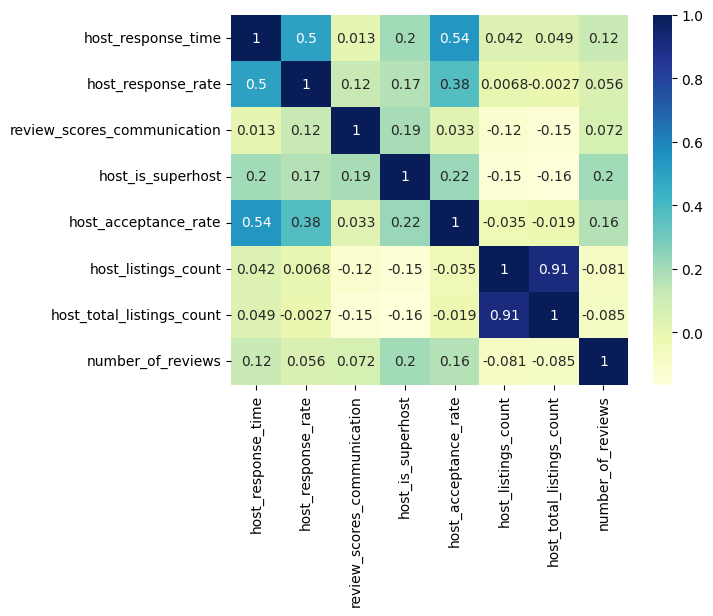

In [396]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df2)
normalized_df2 = pd.DataFrame(scaled_values, columns=df2.columns)
sns.heatmap(normalized_df2.corr(), annot=True, cmap="YlGnBu")

Conclusions from heatmap
- host_is_superhost does not correlate well with any of the chosen features

#### Re-run classifier (KNN gave the best result earlier)

In [ ]:

X = df2[['host_response_time', 'host_response_rate', 'review_scores_communication', 
        'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'number_of_reviews']]
y = df2['host_is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initiation and training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)       # training the model

# Predict and evaluate
y_prediction = knn.predict(X_test)
acc = accuracy_score(y_test, y_prediction)

print(f"KNN accuracy: {acc:.2f}")


KNN accuracy: 0.75


### Conclusions:
- Re-running the model with more features confirms that the result does not improve significantly.   
- Since communicational behaviour does not differentiate superhosts from non-superhosts, this could give the AirBnB team something to think about. Perhaps criteria for superhostness should be changed and better communication encouraged.   
- Lessons from this project:   
    - Take your time to get to know your data. 
    - Take your time to clean your data.  
    - Before moving on to classifiers, inspect the data throroughly. Plotting gives meaningfull information if used correctly.  

# Links from coursematerial  
#### Environment  
* [Anaconda](https://anaconda.org/)
* [Visual Studio Code](https://code.visualstudio.com/blogs/2021/11/08/custom-notebooks)
* [CSC Notebooks](https://www.csc.fi/web/blog/post/-/blogs/notebooks-enemman-aikaa-opetuksen-ytimelle)
* [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html)
* [Google Colab](https://colab.research.google.com/)

#### In general  
[Analytics quadrant](https://journals.sagepub.com/doi/pdf/10.1177/0256090920130401), is divided into the following themes:  
* Descriptive analytics
* Diagnostic analytics
* Predictive analytics
* Prescriptive analytics  

#### Classifiers  
* [Feature engineering](https://medium.com/mindorks/what-is-feature-engineering-for-machine-learning-d8ba3158d97a)  
* [machine-learning-algorithms](https://en.proft.me/2015/12/24/types-machine-learning-algorithms/)  

#### Natural language processing  
* [NLTK](https://www.nltk.org/), though in recent years, [spaCy](https://spacy.io/) has risen alongside and even surpassed NLTK. 
* [Tuomo Hiippala’s learning materials](https://www.youtube.com/channel/UCqI8-flen1SrldnJzkhzMHw)  
* [TF-IDF-algorithm](https://www.tidytextmining.com/tfidf.html)  

#### Useful  
* [Choosing visualization](https://www.sqlbi.com/wp-content/uploads/visuals-reference-sep2018-A3.pdf)
* [Visualization principals](https://books.google.fi/books?hl=en&lr=&id=RRswXg4pJhcC&oi=fnd&pg=PR3&dq=visualizing+data&ots=798mYDjWIa&sig=vZE8vLaz3CoPZwf0yqRZQlxTd0M&redir_esc=y#v=onepage&q=visualizing%20data&f=false)  
* [Planning visualization: Anne-Maritta Tervakari](https://www.slideshare.net/AnneTervakari/visualisointien-suunnittelua)
* [Kaggle-data](https://www.kaggle.com/datasets) 
* [CRISP-DM](https://www.kdnuggets.com/polls/2014/analytics-data-mining-data-science-methodology.html)  
* [Oman talouden seuranta: Python & Power BI](https://mkkvkmn.com/oman-talouden-seuranta/#2024-python-power-bi) Mikko Vikman
